# Personalized Recommendation Systems: Part 2

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rs=123

In [3]:
# load data
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"
ratings_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"

course_df = pd.read_csv(course_genre_url)
ratings_df = pd.read_csv(ratings_url)

In [4]:
course_df.head(3)

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [5]:
ratings_df.head(3)

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5


In [6]:
topics = course_df.columns[~course_df.columns.isin(['COURSE_ID', 'TITLE'])]
topics

Index(['Database', 'Python', 'CloudComputing', 'DataAnalysis', 'Containers',
       'MachineLearning', 'ComputerVision', 'DataScience', 'BigData',
       'Chatbot', 'R', 'BackendDev', 'FrontendDev', 'Blockchain'],
      dtype='object')

## Collaborative Recommender System Using Clustering

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Step 1: Create User Profiles based on ratings and course content

In [8]:
# Step 1: Merge course data with ratings data to get ratings for courses
merged_df = pd.merge(ratings_df, course_df, left_on='item', right_on='COURSE_ID').drop('COURSE_ID', axis=1)

# Step 2: Create a user profile
# First, filter out only the highly rated courses (e.g., rating >= 4)
high_rated_courses = merged_df[merged_df['rating'] >= 4]
# high_rated_courses.head()

# Step 3. Aggregate data by user to create user profiles Create User Profile
user_profiles = high_rated_courses.groupby('user')[topics].mean()
user_profiles.head()

,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
user,,,,,,,,,,,,,,
2,0.384615,0.102564,0.025641,0.282051,0.025641,0.230769,0.0,0.230769,0.307692,0.000000,0.128205,0.128205,0.000000,0.051282
4,0.458333,0.041667,0.000000,0.125000,0.000000,0.208333,0.0,0.333333,0.250000,0.000000,0.083333,0.000000,0.000000,0.041667
5,0.210526,0.078947,0.157895,0.210526,0.000000,0.263158,0.0,0.236842,0.157895,0.026316,0.131579,0.184211,0.026316,0.052632
7,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000


### Step 2. Create User Profiles Vector

In [9]:
# Store features for profile vectors
features = user_profiles.loc[:, user_profiles.columns != 'user']

# Store User IDs
user_ids = user_profiles.loc[:, user_profiles.columns == 'user']

### Step 3. Perform PCA to reduce dimensionality

#### Find best n_components

In [10]:
len(topics)

14

In [11]:
# Define the data (user_x)
data = features  # Make sure user_x is preprocessed and standardized if needed

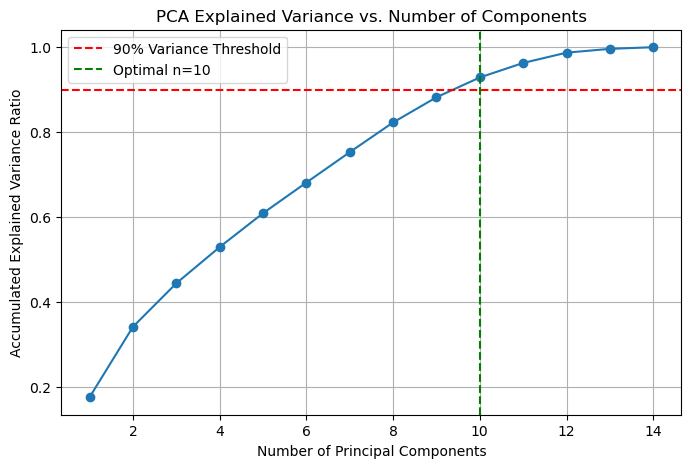

Optimal number of components: 10


In [12]:
# Use StandardScaler to make each feature with mean 0, standard deviation 1
# Instantiating a StandardScaler object
scaler = StandardScaler()

# Standardizing the selected features (feature_names) in the user_profile_df DataFrame
data = scaler.fit_transform(data)

# Define the range for n_components
n_components_range = range(1, 15)

# Store the explained variance ratio for each n_components
explained_variances = []

# Perform PCA for each value of n_components
for n in n_components_range:
    pca = PCA(n_components=n)
    pca.fit(data)
    explained_variances.append(sum(pca.explained_variance_ratio_))  # Accumulated variance

# Find the optimal n_components (threshold 90%)
optimal_n = next(n for n, var in zip(n_components_range, explained_variances) if var >= 0.90)

# Plot the explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(n_components_range, explained_variances, marker='o', linestyle='-')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold")
plt.axvline(x=optimal_n, color='g', linestyle='--', label=f"Optimal n={optimal_n}")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accumulated Explained Variance Ratio")
plt.title("PCA Explained Variance vs. Number of Components")
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal number of components: {optimal_n}")


#### Apply PCA

In [13]:
pca = PCA(n_components=10)
pca.fit(features)

components = pca.fit_transform(data)  

In [14]:
pca_profiles = pd.DataFrame(data=components, columns=[f"PC{i+1}" for i in range(components.shape[1])])
# pca_profiles = pd.concat([user_ids.reset_index(), pca_profiles], axis=1)
# pca_profiles.head()

pca_profiles.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.902231,-0.025661,0.328560,-0.206517,0.320719,0.512515,0.010953,0.088309,0.599146,-0.241041
1,-0.942093,-0.215952,-0.191742,0.302090,0.759503,0.034122,-0.001161,-0.130094,0.119703,0.029770
2,0.078271,-0.071477,0.491151,0.045096,0.397381,0.692401,0.026172,-0.125302,0.653185,0.140869
3,-4.674719,1.633955,0.099019,-1.597494,-1.658152,0.755272,0.076777,0.206838,0.401904,0.566505
4,-5.016830,0.927211,0.287139,-1.453885,0.110316,3.758148,0.068369,1.578282,1.862889,-0.037162


### Step 3. MiniBatch K-Means

In [77]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

In [78]:
batch_size = int(len(pca_profiles)*0.05)  # 5% of data
batch_size

1555

In [79]:
# Step 1: Create a range of potential cluster values (k)
cluster_range = range(2, 30)  # Trying clusters from 2 to 10
inertia_values = []
silhouette_scores = []

# Set a random state for reproducibility
rs = 42

# Data as array
x_train = pca_profiles.values
# Step 2: Fit MiniBatchKMeans for each k and compute inertia and silhouette score
for k in cluster_range:
    print(f"Fitting kmeans (minibatch) with k={k}...")
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=rs, batch_size=batch_size, n_init='auto').fit(x_train)
    # Get inertia (for elbow method)
    inertia_values.append(kmeans.inertia_)
    
    # Calculate silhouette score
    # if k > 1:  # Silhouette score is not defined for k=1
    score = silhouette_score(x_train, kmeans.labels_)
    silhouette_scores.append(score)

Fitting kmeans (minibatch) with k=2...
Fitting kmeans (minibatch) with k=3...
Fitting kmeans (minibatch) with k=4...
Fitting kmeans (minibatch) with k=5...
Fitting kmeans (minibatch) with k=6...
Fitting kmeans (minibatch) with k=7...
Fitting kmeans (minibatch) with k=8...
Fitting kmeans (minibatch) with k=9...
Fitting kmeans (minibatch) with k=10...
Fitting kmeans (minibatch) with k=11...
Fitting kmeans (minibatch) with k=12...
Fitting kmeans (minibatch) with k=13...
Fitting kmeans (minibatch) with k=14...
Fitting kmeans (minibatch) with k=15...
Fitting kmeans (minibatch) with k=16...
Fitting kmeans (minibatch) with k=17...
Fitting kmeans (minibatch) with k=18...
Fitting kmeans (minibatch) with k=19...
Fitting kmeans (minibatch) with k=20...
Fitting kmeans (minibatch) with k=21...
Fitting kmeans (minibatch) with k=22...
Fitting kmeans (minibatch) with k=23...
Fitting kmeans (minibatch) with k=24...
Fitting kmeans (minibatch) with k=25...
Fitting kmeans (minibatch) with k=26...
Fitting 

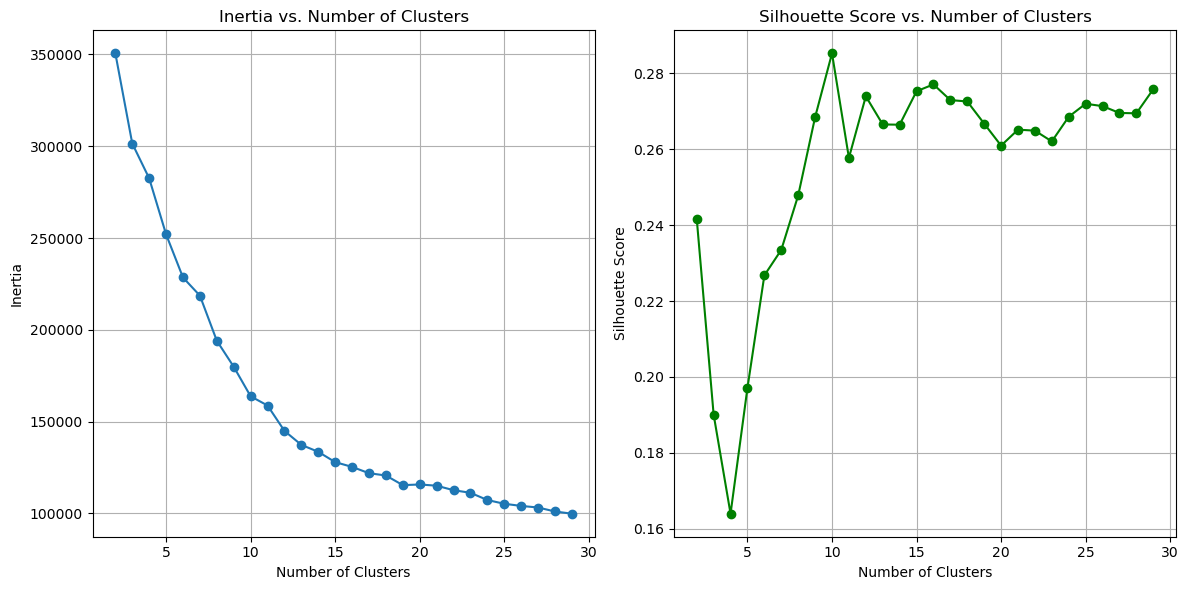

In [80]:
# Step 3: Plot the results to find the best k
plt.figure(figsize=(12, 6))

# Plot inertia (elbow method)
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o')
plt.title("Inertia vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)

# Plot silhouette score
plt.subplot(1, 2, 2)
# Adjusted range to ensure the lengths match
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [52]:
x_train = pca_profiles.values

In [60]:
### REPEAT FOR K-means ++
cluster_range = range(2, 30)  # Trying clusters from 2 to 10
inertia_values = []
silhouette_scores = []

# Set a random state for reproducibility
rs = 42

# Fit models and store inertia values
for k in cluster_range:
    print(f"Training K-Means++ on k={k}... ")
    model = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(x_train)
    inertia_values.append(model.inertia_)

    # Calculate silhouette score
    # if k > 1:  # Silhouette score is not defined for k=1
    score = silhouette_score(x_train, model.labels_)
    silhouette_scores.append(score)

Training K-Means++ on k=2... 
Training K-Means++ on k=3... 
Training K-Means++ on k=4... 
Training K-Means++ on k=5... 
Training K-Means++ on k=6... 
Training K-Means++ on k=7... 
Training K-Means++ on k=8... 
Training K-Means++ on k=9... 
Training K-Means++ on k=10... 
Training K-Means++ on k=11... 
Training K-Means++ on k=12... 
Training K-Means++ on k=13... 
Training K-Means++ on k=14... 
Training K-Means++ on k=15... 
Training K-Means++ on k=16... 
Training K-Means++ on k=17... 
Training K-Means++ on k=18... 
Training K-Means++ on k=19... 
Training K-Means++ on k=20... 
Training K-Means++ on k=21... 
Training K-Means++ on k=22... 
Training K-Means++ on k=23... 
Training K-Means++ on k=24... 
Training K-Means++ on k=25... 
Training K-Means++ on k=26... 
Training K-Means++ on k=27... 
Training K-Means++ on k=28... 
Training K-Means++ on k=29... 


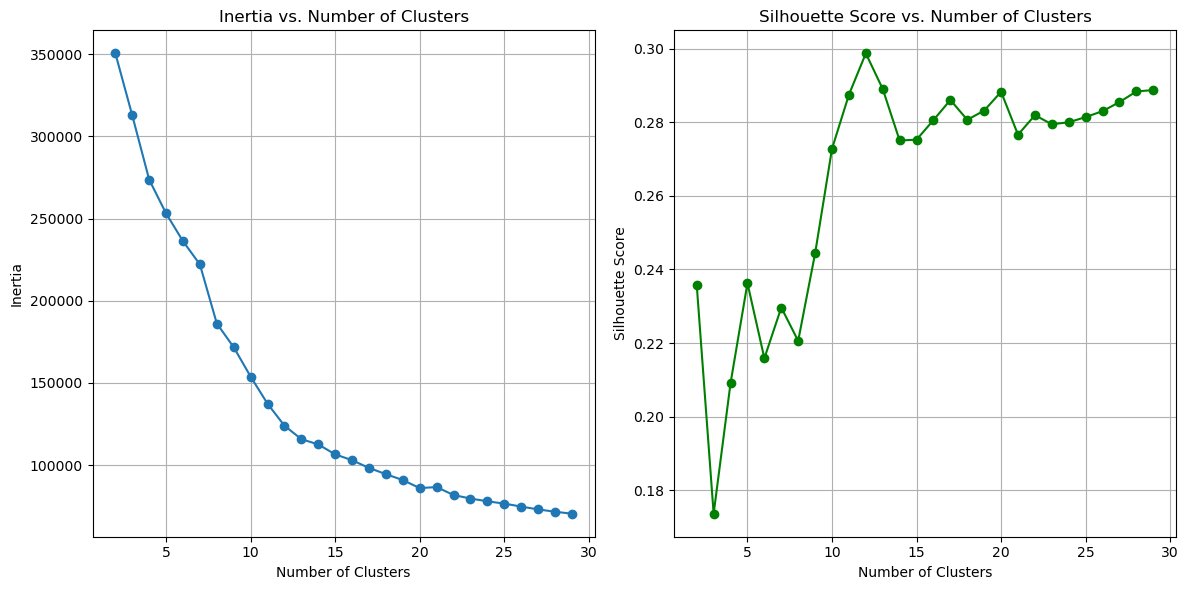

In [61]:
# Step 3: Plot the results to find the best k
plt.figure(figsize=(12, 6))

# Plot inertia (elbow method)
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o')
plt.title("Inertia vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)

# Plot silhouette score
plt.subplot(1, 2, 2)
# Adjusted range to ensure the lengths match
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [86]:
best_k = 10

model = MiniBatchKMeans(n_clusters=best_k, random_state=rs, batch_size=batch_size, n_init='auto')
model.fit(x_train)

cluster_labels = model.labels_
# dfx = user_profile_df.copy() 
# dfx['cluster']=cluster_labels

# dfx.cluster.value_counts() 

In [87]:
profiles = user_profiles.copy()
profiles['cluster']=cluster_labels

profiles['cluster'].value_counts()

cluster
2    6720
6    5797
9    4927
7    4643
0    2891
3    2155
1    1820
5     975
8     699
4     478
Name: count, dtype: int64

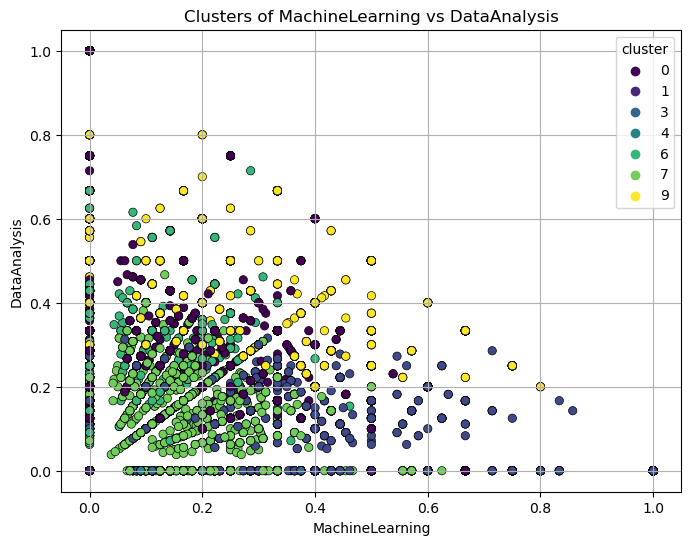

In [89]:
def plot_clusters(df, feature1, feature2, hue):
    """
    Generates a scatter plot of df for feature1 and feature2, 
    coloring the datapoints by the value of hue (cluster labels).
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=feature1, y=feature2, hue=hue, palette="viridis", edgecolor="black")
    plt.title(f"Clusters of {feature1} vs {feature2}")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(title=hue)
    plt.grid(True)
    plt.show()


plot_clusters(profiles, 'MachineLearning', 'DataAnalysis', 'cluster')

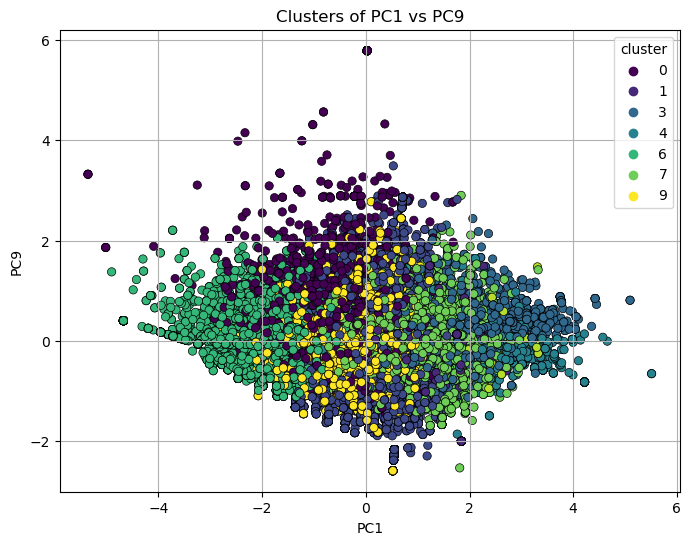

In [92]:
profiles_components = pca_profiles.copy()
profiles_components['cluster']=cluster_labels

plot_clusters(profiles_components, 'PC1', 'PC9', 'cluster')

### Step 4. Label Users and provide recommendations

In [111]:
user_ratings = ratings_df[['user', 'item']].copy()

user_segments = user_ids.reset_index()
user_segments['cluster'] = cluster_labels

user_segments = pd.merge(user_ratings, user_segments, left_on='user', right_on='user')
user_segments.head()

,user,item,cluster
0,1889878,CC0101EN,7
1,1889878,ML0120ENv2,7
2,1889878,DV0151EN,7
3,1889878,HCC104EN,7
4,1889878,BD0211EN,7


In [113]:
# Extracting the 'item' and 'cluster' columns from the test_users_labelled DataFrame
courses_cluster = user_segments[['item', 'cluster']]

# Adding a new column 'count' with a value of 1 for each row in the courses_cluster DataFrame
courses_cluster['count'] = [1] * len(courses_cluster)

# Grouping the DataFrame by 'cluster' and 'item', aggregating the 'count' column with the sum function,
# and resetting the index to make the result more readable
courses_cluster_grouped = courses_cluster.groupby(['cluster','item']).agg(enrollments=('count','sum')).reset_index()

courses_cluster_grouped.head(7)

,cluster,item,enrollments
0,0,AI0111EN,14
1,0,BC0101EN,432
2,0,BC0201EN,69
3,0,BC0202EN,32
4,0,BD0101EN,1395
5,0,BD0111EN,1051
6,0,BD0115EN,238


In [118]:
# ## - For each user, first finds its cluster label
# # Step 1: Identify each user's cluster label
# user_clusters = user_segments[['user', 'cluster']]

# # Step 2: Find popular courses in each cluster (threshold: 100 enrollments)
# popular_courses = courses_cluster_grouped[courses_cluster_grouped['enrollments'] > 100]

# # Step 3: Get each user's currently enrolled courses
# user_enrollments = user_segments[['user', 'item']].groupby('user')['item'].apply(set).reset_index()

# # Step 4: Generate course recommendations
# recommendations = []

#     ## - First get all courses belonging to the same cluster and figure out what are the popular ones (such as course enrollments beyond a threshold like 100)
    
#     ## - Get the user's current enrolled courses
    
#     ## - Check if there are any courses on the popular course list which are new/unseen to the user. 
    
#     ## If yes, make those unseen and popular courses as recommendation results for the user
# for _, row in user_clusters.iterrows():
#     user = row['user']
#     cluster = row['cluster']
    
#     # Get popular courses in the user's cluster
#     cluster_courses = popular_courses[popular_courses['cluster'] == cluster]['item'].tolist()
    
#     # Get user's enrolled courses
#     user_courses = user_enrollments[user_enrollments['user'] == user]['item'].values[0] if user in user_enrollments['user'].values else set()
    
#     # Find unseen popular courses
#     unseen_courses = list(set(cluster_courses) - user_courses)
    
#     # Store recommendations
#     if unseen_courses:
#         recommendations.append({'user': user, 'recommended_courses': unseen_courses})



# # Convert to DataFrame
# recommendations_df = pd.DataFrame(recommendations)

# # Display recommendations
# recommendations_df.head()


# Step 1: Identify each user's cluster label
user_clusters = user_segments[['user', 'cluster']]

# Step 2: Find popular courses in each cluster (threshold: 100 enrollments)
popular_courses = courses_cluster_grouped[courses_cluster_grouped['enrollments'] > 100]

# Step 3: Get each user's currently enrolled courses
user_enrollments = user_segments[['user', 'item']].groupby('user')['item'].apply(set).reset_index()

# Step 4: Generate course recommendations
recommendations = []

# For each user in the clusters
for _, row in user_clusters.iterrows():
    user = row['user']
    cluster = row['cluster']
    
    # Get popular courses in the user's cluster
    cluster_courses = popular_courses[popular_courses['cluster'] == cluster]['item'].tolist()
    
    # Get user's enrolled courses
    user_courses = user_enrollments[user_enrollments['user'] == user]['item'].values[0] if user in user_enrollments['user'].values else set()
    
    # Find unseen popular courses
    unseen_courses = list(set(cluster_courses) - user_courses)
    
    # If there are unseen courses, prepare them for recommendation
    if unseen_courses:
        for course_id in unseen_courses:
            recommendations.append({'user': user, 'cluster': cluster, 'recommended_course_id': course_id})

# Convert to DataFrame
recommendations_df = pd.DataFrame(recommendations)




In [120]:
# Step 5: Add course titles from course_df
recommendations_df = recommendations_df.merge(course_df[['COURSE_ID', 'TITLE']], left_on='recommended_course_id', right_on='COURSE_ID', how='left')

# Drop the redundant COURSE_ID column
recommendations_df = recommendations_df.drop(columns=['COURSE_ID'])

# Display recommendations
recommendations_df.head()


,user,cluster,recommended_course_id,TITLE
0,1889878,7,LB0103ENv1,reactive architecture domain driven design
1,1889878,7,CO0301EN,getting started with microservices with istio ...
2,1889878,7,DS0201EN,end to end data science on cloudpak for data
3,1889878,7,BD0212EN,spark fundamentals ii
4,1889878,7,BD0123EN,simplifying data pipelines with apache kafka


In [140]:
# Add courses ratings by clusters
ratings_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


In [157]:
ratings_clusters = pd.merge(ratings_df, user_segments, left_on=['user', 'item'], right_on=['user','item'])

# aggregate ratings by clusters and item
ratings_aggregated = ratings_clusters.groupby(['cluster', 'item'])['rating'].agg(['mean', 'sum', 'count']).reset_index()
ratings_aggregated['mean'] = ratings_aggregated['mean'].astype(int)

ratings_aggregated.head()

,cluster,item,mean,sum,count
0,0,AI0111EN,3,53,14
1,0,BC0101EN,3,1639,432
2,0,BC0201EN,3,271,69
3,0,BC0202EN,3,116,32
4,0,BD0101EN,3,5523,1395


In [164]:
ratings_df[ratings_df.user==this_user]

,user,item,rating
4,779563,DS0101EN,3
84528,779563,ST0101EN,5
116682,779563,BC0101EN,5
136492,779563,BD0101EN,3
139584,779563,DA0101EN,3
143035,779563,PY0101EN,4
173195,779563,DV0101EN,4


In [179]:
# Example usage
this_user = 779563
completed_course = 'ML0151EN'
min_rating = 4

# Step 1: Get the cluster of the user from the recommendations_df
user_cluster = recommendations_df[recommendations_df.user == this_user]['cluster'].values[0]

# Step 2: Filter ratings_aggregated to get courses in the same cluster with mean rating >= min_rating
filtered_courses = ratings_aggregated[(ratings_aggregated['cluster'] == user_cluster) & (ratings_aggregated['mean'] >= min_rating)]

# Step 3: Get recommended courses (titles) for the filtered courses
recommended_course_ids = filtered_courses['item'].tolist()

# Step 4: Get the recommendations for this user from recommendations_df, and drop duplicates
its_recommendations = recommendations_df[recommendations_df.user == this_user].drop_duplicates()

# Step 5: Check if the completed course exists in the recommendations, and get its title
if completed_course in its_recommendations['recommended_course_id'].values:
    this_course = its_recommendations[its_recommendations.recommended_course_id == completed_course]['TITLE'].values[0]
else:
    print(f"The course `{completed_course}` was not found in the recommendations for user {this_user}.")
    this_course = None  # Set to None if the course is not found

# Step 6: If `this_course` is found, get the other courses from the recommended courses list that are not already completed
if this_course:
    other_courses = [course for course in its_recommendations['TITLE'] if course != this_course and its_recommendations[its_recommendations['TITLE'] == course]['recommended_course_id'].values[0] in recommended_course_ids]

    # Step 7: Output the results
    print(f'Thank you for completing the course: `{this_course}`')
    print('-'*40)
    print('You may be interested also in the following courses:')
    for course in other_courses:
        print(f">> {course}")
else:
    print("No recommendations to display due to missing completed course.")



Thank you for completing the course: `machine learning with r`
----------------------------------------
You may be interested also in the following courses:
>> text analytics 101
>> mathematical optimization for business problems
>> watson analytics 101
>> machine learning with python
>> machine learning with python
>> digital analytics   regression
>> accelerating deep learning with gpu
>> introduction to containers  kubernetes  and openshift v2
>> accelerating deep learning with gpu
>> spark fundamentals i


### Unique Suggestions per Cluster


In [181]:
# Filter ratings_aggregated to get courses in the same cluster with mean rating >= min_rating
filtered_courses = ratings_aggregated[ratings_aggregated['mean'] >= min_rating]

# Filter recommendations_df to only include recommended courses in the filtered list from ratings_aggregated
valid_recommendations = recommendations_df[recommendations_df['recommended_course_id'].isin(filtered_courses['item'])]

# Count the number of unique suggestions per cluster
unique_suggestions_per_cluster = valid_recommendations.groupby('cluster')['recommended_course_id'].nunique().reset_index()

# Rename the columns for clarity
unique_suggestions_per_cluster.columns = ['cluster', 'unique_suggestions_count']

# Display the result
unique_suggestions_per_cluster

,cluster,unique_suggestions_count
0,0,50
1,1,7
2,2,55
3,3,28
4,4,6
5,6,55
6,7,81
7,8,1
8,9,43


### Top Recommendations per cluster

In [185]:
# Step 2: Find popular courses in each cluster (threshold: 100 enrollments)
popular_courses = courses_cluster_grouped[courses_cluster_grouped['enrollments'] > 100]


# Find the course with the top enrollments for each cluster
top_courses_per_cluster = popular_courses.loc[popular_courses.groupby('cluster')['enrollments'].idxmax()]

# # Display the results
# top_courses_per_cluster = top_courses_per_cluster[['cluster', 'item', 'TITLE', 'enrollments']]

# print(top_courses_per_cluster)

In [186]:
top_courses_per_cluster

,cluster,item,enrollments
90,0,RP0101EN,2339
136,1,CNSC02EN,1128
246,2,DS0101EN,4452
347,3,CO0101EN,1618
468,4,LB0101ENv1,377
511,5,CB0103EN,975
548,6,BD0111EN,4628
658,7,BC0101EN,3293
774,8,BC0201EN,680
918,9,PY0101EN,4168


In [197]:
# For User selected cluster, top 10 courses
popular_courses[popular_courses.cluster==9].sort_values(by='enrollments',ascending=False).reset_index(drop=True).head(10)

,cluster,item,enrollments
0,9,PY0101EN,4168
1,9,DA0101EN,3839
2,9,DV0101EN,3309
3,9,ML0101ENv3,2688
4,9,DS0101EN,2527
5,9,DS0105EN,1494
6,9,DS0103EN,1459
7,9,ML0115EN,1406
8,9,ST0101EN,1358
9,9,BD0101EN,1336


In [193]:
recommendations_df['cluster'][recommendations_df.user==779563].iloc[0]

9

In [206]:
course_df[['COURSE_ID', 'TITLE']][course_df.COURSE_ID=='PY0101EN']

,COURSE_ID,TITLE
188,PY0101EN,python for data science


# SURPRISE AND KNN

In [22]:
ratings_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


In [2]:
%%capture
!pip install scikit-surprise

In [6]:
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV, RandomizedSearchCV


In [9]:
# Instantiate reader

# Read the course rating dataset with columns user item rating
reader = Reader(
    line_format='user item rating', sep=',', skip_lines=1, rating_scale=(2, 3))


In [10]:
# Temporarily store the file locally
ratings_df.to_csv("course_ratings.csv", index=False)

In [11]:
!pwd

/home/wsuser/work


In [12]:
# Load dataset from local
course_dataset = Dataset.load_from_file('/home/wsuser/work/course_ratings.csv', reader=reader)

In [13]:
# Use surprise train-test split with READER
trainset, testset = train_test_split(course_dataset, test_size=.3)

In [14]:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the trainingset")

Total 31397 users and 124 items in the trainingset


In [16]:
# Define the similarity option (you can experiment with other similarity options like 'cosine', 'pearson', etc.)
sim_option = {
    'name': 'cosine',  # You can also use 'pearson' or other similarity measures
    'user_based': False,  # Use item-based similarity
}

# Create the KNNBasic model
model = KNNBasic(sim_options=sim_option)

# Train the model on the trainset
model.fit(trainset)

# Record predictions on the testset
predictions = model.test(testset)

# Compute the RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)

# Print the RMSE result
print(f"RMSE: {rmse}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2890
RMSE: 1.289004556469686


### Tuning

In [51]:
# Define the hyperparameter grid
param_grid = {
    'k': [5, 10, 15],  # Number of neighbors
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Similarity measures
        'user_based': [False]
    }
}



# # Perform grid search
# grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=5, n_jobs=2)
# grid_search.fit(course_dataset)  # Use your dataset

# # Print best RMSE score and best parameters
# print(f"Best RMSE: {grid_search.best_score['rmse']}")
# print(f"Best Parameters: {grid_search.best_params['rmse']}")



# Randomizer grid search
random_search = RandomizedSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=5, n_iter=5, n_jobs=2)
random_search.fit(course_dataset)

# Print best RMSE score and best parameters
print(f"Best RMSE: {random_search.best_score['rmse']}")
print(f"Best Parameters: {random_search.best_params['rmse']}")


Best RMSE: 1.2895089797022696
Best Parameters: {'k': 10, 'sim_options': {'name': 'cosine', 'user_based': False}}


### Try Mode models

In [20]:
# Define the hyperparameter grid
param_grid = {
    'k': [5, 10, 15, 20],  # Number of neighbors
    'min_k':[2, 3, 5],
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Similarity measures
        'user_based': [False]
    }
}

In [17]:
sim_options = {'name': 'cosine', 'user_based': False}
model2 = KNNWithMeans(k=10, min_k=2, sim_options=sim_options)
model2.fit(trainset)

# Record predictions on the testset
predictions = model2.test(testset)

# Compute the RMSE (Root Mean Squared Error)
rmse2 = accuracy.rmse(predictions)

# Print the RMSE result
print(f"RMSE: {rmse2}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2891
RMSE: 1.289069413254954


In [21]:
### TUNE

# Randomizer grid search
random_search = RandomizedSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=5, n_iter=5, n_jobs=2)
random_search.fit(course_dataset)

# Print best RMSE score and best parameters
print(f"Best RMSE: {random_search.best_score['rmse']}")
print(f"Best Parameters: {random_search.best_params['rmse']}")


Best RMSE: 1.289518312542621
Best Parameters: {'k': 20, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': False}}


In [19]:
# Define similarity options for user-based filtering
sim_options = {
    'name': 'cosine',  # Try 'pearson' as well
    'user_based': False  # Set to True for user-based filtering
}

# Create the KNNWithZScore model
model3 = KNNWithZScore(k=20, min_k=5, sim_options=sim_options)
model3.fit(trainset)

# Record predictions on the testset
predictions = model3.test(testset)

# Compute the RMSE (Root Mean Squared Error)
rmse3 = accuracy.rmse(predictions)

# Print the RMSE result
print(f"RMSE: {rmse3}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2890
RMSE: 1.2890078779261753


In [22]:
# Randomizer grid search
random_search = RandomizedSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=5, n_iter=5, n_jobs=2)
random_search.fit(course_dataset)

# Print best RMSE score and best parameters
print(f"Best RMSE: {random_search.best_score['rmse']}")
print(f"Best Parameters: {random_search.best_params['rmse']}")


Best RMSE: 1.2895457396152161
Best Parameters: {'k': 15, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}}


### SURPRISE AND NMF

In [7]:
from surprise import NMF

In [13]:

# Define the NMF model with specified hyperparameters
model = NMF(n_factors=32, init_low=0.5, init_high=5.0, verbose=False, random_state=123)

# Train the model on the trainset
model.fit(trainset)

# Record predictions on the testset
predictions = model.test(testset)

# Compute RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)

# Print the RMSE result
print(f"RMSE: {rmse}")


RMSE: 1.2899
RMSE: 1.2899024294405703


In [15]:
### TUNING

from surprise import NMF
from surprise.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_factors': [10, 20, 30],  # Number of latent factors
    'n_epochs': [20, 50, 70],  # Number of training iterations
    'reg_pu': [0.02, 0.05, 0.1],  # Regularization for users
    'reg_qi': [0.02, 0.05, 0.1],  # Regularization for items
    'init_low': [0.1, 0.3],  # Lower bound for factor initialization
    'init_high': [4.0, 5.0]  # Upper bound for factor initialization
}

# Perform grid search
grid_search = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
grid_search.fit(course_dataset)

# Print best RMSE score and parameters
print(f"Best RMSE: {grid_search.best_score['rmse']}")
print(f"Best Parameters: {grid_search.best_params['rmse']}")


Best RMSE: 1.2895092624731277
Best Parameters: {'n_factors': 10, 'n_epochs': 20, 'reg_pu': 0.02, 'reg_qi': 0.02, 'init_low': 0.1, 'init_high': 4.0}


In [18]:
# Define the NMF model with specified hyperparameters
model = NMF(
    n_factors=10, 
    n_epochs=20,
    reg_pu=0.02,
    reg_qi=0.02,
    init_low=0.1, 
    init_high=3.0, 
    verbose=False, 
    random_state=123)

# Train the model on the trainset
model.fit(trainset)

# Record predictions on the testset
predictions = model.test(testset)

# Compute RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)

# Print the RMSE result
print(f"RMSE: {rmse}")


RMSE: 1.2915
RMSE: 1.2915458330737486
